# HEXTOF-processor binning procedure tutorial

This notebook is an example of how to use the hextof-processor to process raw data from the FLASH DAQ raw data format, into binned arrays. These can then be used for analysis with the users favourite tools.

The procedure described here is divided in two sections. First, a direct binning in the raw data axis is presented. The second includes calibration of Binding Energy and pump-probe time delay axes and allows binning in the desired physical quantities.

This guide is intended to be used with the example raw data provided in this repository, and should be run from its original location.


## 0. Imports
Import required libraries

In [1]:
import sys, os
from datetime import datetime
from tqdm.notebook import tnrange

# import numeric packages
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib.pyplot as plt

# invoke interactive matplotlib plots
%matplotlib notebook 

# hextof-processor imports
sys.path.append(os.path.dirname(os.getcwd()) ) # add hextof-processor to path
from processor.DldFlashDataframeCreator import DldFlashProcessor
from processor.utilities import calibration, diagnostics, misc, io, vis

### 1. Read raw data and generate single event dataframe

In [2]:
prc = DldFlashProcessor()
# load the correct configuration for the dataset you want to read.
# This can be different for each beamtime.
prc.load_settings('tutorial') 
prc.DATA_RAW_DIR = '../tutorial/raw' # manually overwrite data folder to use the tutorial dataset
prc.DATA_PARQUET_DIR = '../tutorial/parquet' # manually overwrite parquet data folder. it is STRONGLY recomendend to use an SSD drive here.
prc.runNumber = 22097 # run number of the example data given for this tutorial
prc.readData() # read the raw data and generate the single event tables
prc.storeDataframes() # store the single event tables as parquet files.    



Loaded settings from tutorial.ini
loading data...
Reading DAQ data from run 22097... Please wait...
Run 22097
Macrobunches: 7,064  from 99,007,477 to 99,014,541 
Total electrons: 6,952,657, electrons/Macrobunch 984
Creating dataframes... Please wait...
[########################################] | 100% Completed |  4.6s
Electron dataframe created.
Microbunch dataframe created.
Reading Complete.
Creating parquet container ../tutorial/parquetrun22097
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  0.9s


At this point, the prc object can be re-created using the fresh parquet dataset only. This improves memory efficiency of the overall code. However, generating the parquet intermediate format is not mandatory, and binning can be performed, on small runs, also on the raw data loaded in memory.



In [3]:
# **OPTIONAL** clear memory and load the single event tables from parquet:
prc = DldFlashProcessor() # overwrite the processor with a fresh new instance
prc.runNumber = 22097
prc.DATA_PARQUET_DIR = '../tutorial/parquet' # manually overwrite parquet data folder. it is STRONGLY recomendend to use an SSD drive here.
prc.readDataframes() # load data from single event tables saved as parquet

no run info available.
Loaded data form parquet file


## 2. Basic binning

### 2.1 define binning range

In [4]:
# Time of flight parameters
tof_from = 620#180
tof_to = 660
tof_step = 0.003 # the bigger number between this and the original step size is used in the final binning size definition.

# pump-probe delay parameters
delay_from = -517
delay_to = -512.5
delay_step = 0.05

# detector position parameters, valid both in x and y directions
dld_from=0
dld_to=3000
dld_step=30

### 2.2 add binning parameters to the processor

In [5]:
prc.resetBins() # ensure there is no previous binning axes assigned.
prc.addBinning('dldTime', tof_from,tof_to,tof_step);
prc.addBinning('delayStage',delay_from,delay_to,delay_step);
# prc.addBinning('dldPosX',dld_from,dld_to,dld_step);
# prc.addBinning('dldPosY',dld_from,dld_to,dld_step);

### 2.3 compute binned arrays

In [6]:
result = prc.computeBinnedData()


Failed creating metadata: 'forced to skip metadata creation'


# 2. Binning on calibrated axes

## 2.1 calibrate energy axis
Create a column **Energy** in the dataframe, with the values of binding energy in eV

In [7]:
prc.calibrateEnergy(toffset=355.,eoffset=113.29,l=0.8, # parameters defined by microscope settings. See documentation for details.
    useJitter=True,jitterAmplitude=1,jitterType='normal')# jitter parameters used to remove artifacts.

## 2.2 calibrate pumpProbe Time
Create a **pumpProbeTime** axis in the dataframe, by transforming stage delay values to the pump-probe corrected axis

In [8]:
prc.calibratePumpProbeTime(t0=-514.96)

## 2.3 bin the data on the corrected axes

In [9]:
prc.resetBins()
prc.addBinning('energy',-40,2,0.01);
prc.addBinning('pumpProbeTime',-14,5,0.1);
result = prc.computeBinnedData()


Failed creating metadata: 'forced to skip metadata creation'


<IPython.core.display.Javascript object>


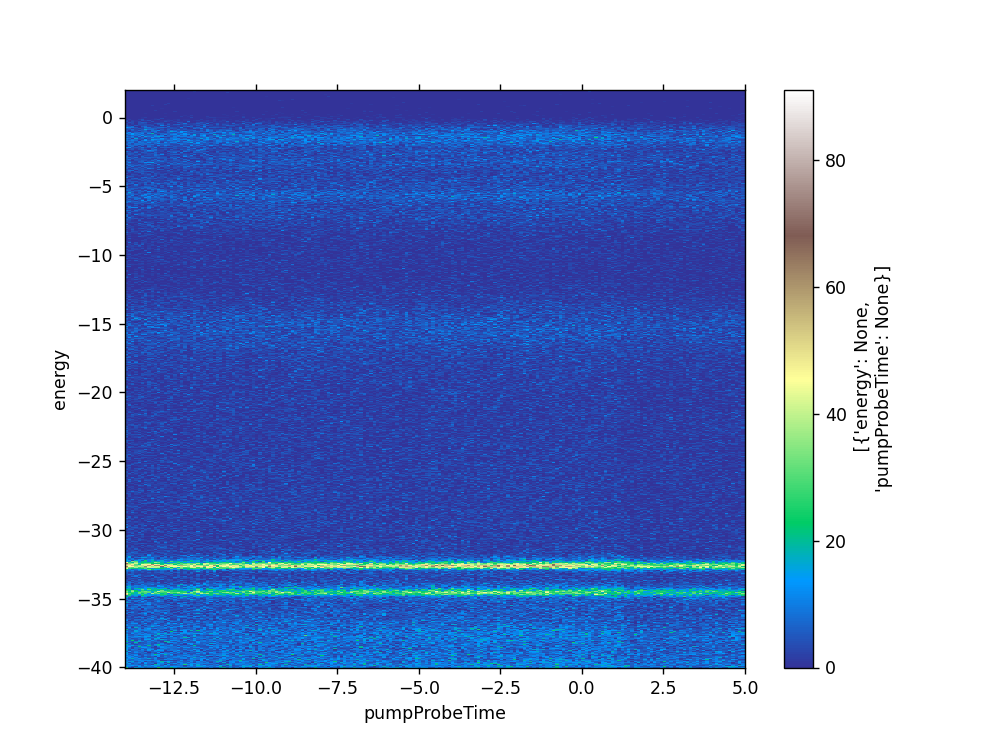

In [10]:
plt.figure()
result.plot(cmap='terrain')

## 2.3b bin the data and normalize to the delay stage histogram
The sweeping mode of the delay stage features long stops on the edges of the scanning range, which lead to artifacts in the number of counts as function of delay stage. In order to correct for this, it is possible to bin additionally on the delay stage and normalise to this axis.

***ATTENTION: this is can be computationally heavy, since it requires an additional axis on which to bin. Might fail on smaller machines.***

In [11]:
prc.resetBins()
energy_bin_parameters = -40, 2, 0.01 # from,to and step, in eV
time_bin_parameters = -15,6.5, 0.05 # from,to and step, in ps
ds_min,ds_max = dask.compute(prc.dd['delayStage'].min(),prc.dd['delayStage'].max())# calculate the range of the delay Stage


prc.addBinning('pumpProbeTime', *time_bin_parameters) # uncommenting this will allow the binning to be in time, but this cannot be performed on small memory computers.
prc.addBinning('delayStage',ds_min,ds_max, time_bin_parameters[2]*4) # bin the full delay stage range
prc.addBinning('energy', *energy_bin_parameters)

result = prc.normalizeDelay(prc.computeBinnedData(), ax='delayStage', preserve_mean=True).sum('delayStage')



Failed creating metadata: 'forced to skip metadata creation'
Computing normalization array along delayStage
[########################################] | 100% Completed |  2.1s
normalized delayStage data found along axis 1


<IPython.core.display.Javascript object>


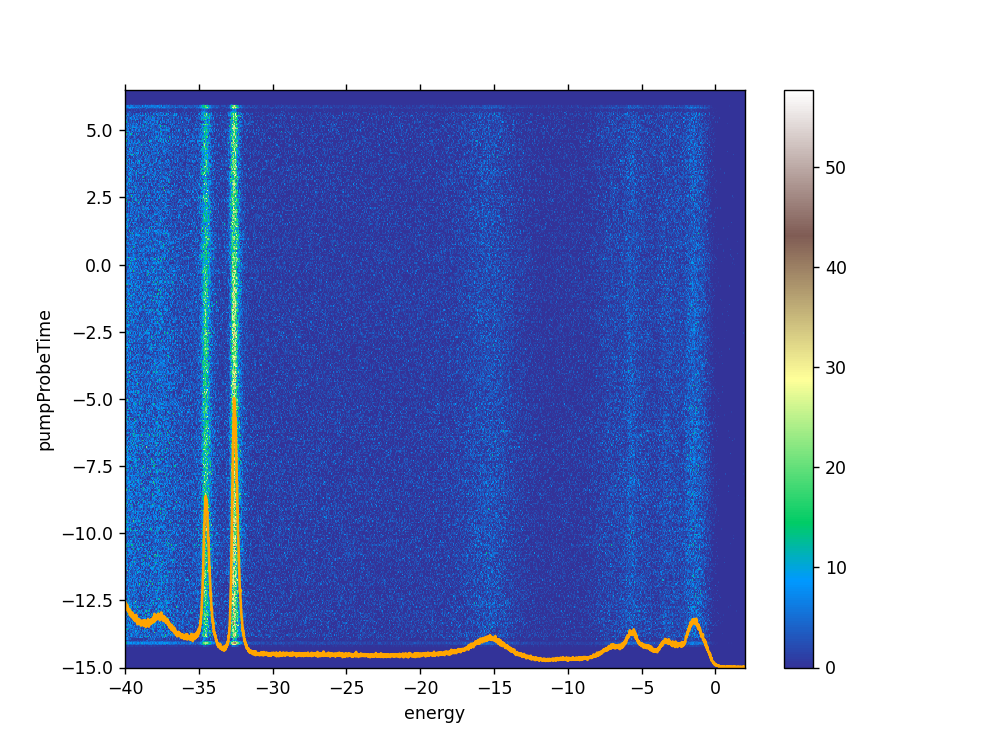

In [12]:
plt.figure()
result.plot(cmap='terrain')
edc = result.mean('pumpProbeTime')
edc /= edc.max()
plt.plot(edc.energy,10*edc+result.pumpProbeTime.min(),color='orange')

## 2.5 normalize EDCs to emphasize pumpProbe effects

<IPython.core.display.Javascript object>


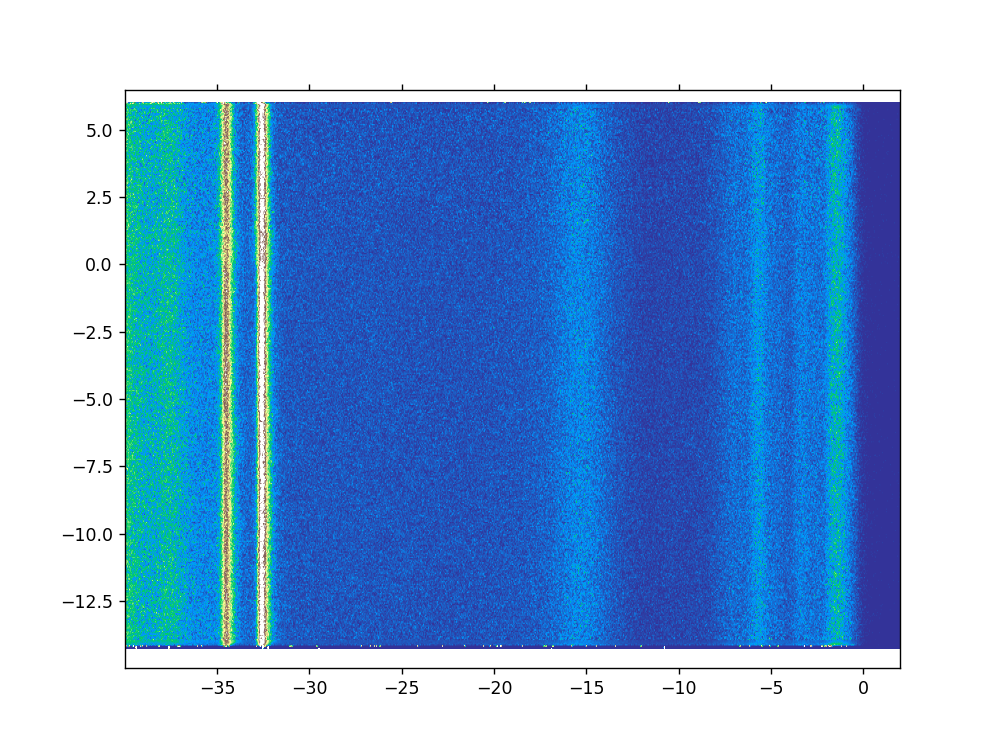

C:\Users\stein\.conda\envs\hextoftest\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
plt.figure()
result_edcnorm = result.transpose('pumpProbeTime','energy')
result_edcnorm.values = result_edcnorm.values / result_edcnorm.mean('energy').values[:,None]
ext = result_edcnorm.energy[0],result_edcnorm.energy[-1],result_edcnorm.pumpProbeTime[0],result_edcnorm.pumpProbeTime[-1]
plt.imshow(result_edcnorm,origin='lower',aspect='auto',cmap='terrain',extent=ext,clim=(0,10))

# 3. Saving binned data
Binned data can be saved as .h5 or tiff stacks (up to 4D).

In [14]:
io.save_binned(result_edcnorm,file_name='run22097_tutorial',path='../tutorial/raw/',format='h5')
io.save_binned(result_edcnorm,file_name='run22097_tutorial',path='../tutorial/raw/',format='tiff')

A file named run22097_tutorial.h5 already exists. Overwrite it? [y/n or r for rename]y
saving data to ../tutorial/raw/run22097_tutorial.h5
Saving complete!
A file named run22097_tutorial.tiff already exists. Overwrite it? [y/n or r for rename]y
tif stack dimension order: ['pumpProbeTime', 'energy', 'C', 'Y', 'X', 'S']
Successfully saved ../tutorial/raw/run22097_tutorial.tiff
